In [41]:
pip install gymnasium stable_baselines3 networkx torch_geometric

In [42]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.monitor import Monitor

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

import os
from stable_baselines3.common.logger import configure


#### Reward tracking

In [43]:
class RewardTrackerCallback(BaseCallback):
    def __init__(self, verbose=0, check_freq=1000, window_size=100):
        super(RewardTrackerCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.window_size = window_size
        self.rewards = []
        self.timesteps = []

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward from Monitor
            x, y = ts2xy(load_results(self.model.logger.dir), 'timesteps')
            if len(y) >= self.window_size:
                mean_reward = np.mean(y[-self.window_size:])
                self.rewards.append(mean_reward)
                self.timesteps.append(x[-1])
        return True

#### Baseline Algo

In [44]:
# Set a log directory
log_dir = "./logs_baseline/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make("CartPole-v1")
# Ensure that the Monitor writes to log_dir/monitor.csv
env = Monitor(env, log_dir + "monitor.csv")
env = DummyVecEnv([lambda: env])
env = VecMonitor(env)

# Create the model
model = PPO("MlpPolicy", env, verbose=0)

# Configure the logger to use the same directory
# This ensures load_results() and logger.dir match
new_logger = configure(log_dir, ["stdout", "csv", "tensorboard"])
model.set_logger(new_logger)

baseline_callback = RewardTrackerCallback(check_freq=1000, window_size=20)
model.learn(total_timesteps=50000, callback=baseline_callback)

baseline_rewards = baseline_callback.rewards
baseline_timesteps = baseline_callback.timesteps

Logging to ./logs_baseline/


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.1     |
|    ep_rew_mean     | 22.1     |
| time/              |          |
|    fps             | 860      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 25          |
| time/                   |             |
|    fps                  | 403         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007232317 |
|    clip_fraction        | 0.0702      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | -0.00172    |
|    learning_rate        | 0.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


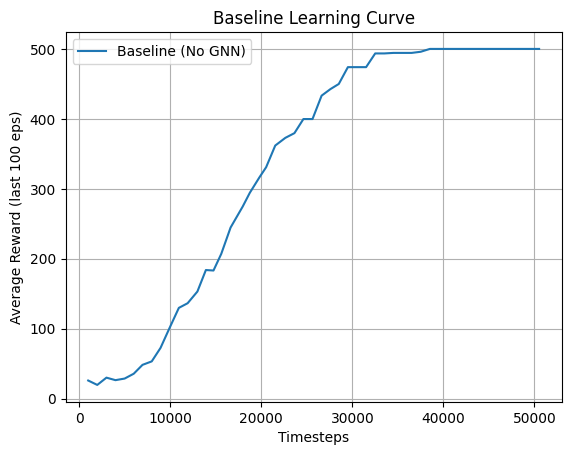

In [45]:
# Plot the baseline learning curve
plt.plot(baseline_timesteps, baseline_rewards, label="Baseline (No GNN)")
plt.xlabel("Timesteps")
plt.ylabel("Average Reward (last 100 eps)")
plt.title("Baseline Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

#### GNN - Approach

In [46]:
def collect_transitions(env_id="CartPole-v1", num_steps=10000):
    env = gym.make(env_id)
    transitions = []
    obs, _ = env.reset()
    for _ in range(num_steps):
        # Random action
        action = env.action_space.sample()
        next_obs, reward, terminated, truncated, info = env.step(action)
        transitions.append((obs, action, reward, next_obs))
        obs = next_obs
        if terminated or truncated:
            obs, _ = env.reset()
    env.close()
    return transitions

transitions = collect_transitions(num_steps=100000)
print("Collected transitions:", len(transitions))


Collected transitions: 100000


In [47]:
def create_bins(low, high, bins):
    # Creates equally spaced bins between low and high
    return np.linspace(low, high, bins+1)

# For CartPole:
# Observation space bounds:
# Cart position: [-4.8, 4.8]
# Cart velocity: [-Inf, Inf] (we'll limit to [-3,3] for practical binning)
# Pole angle: [-0.418,0.418] approx (-24°,24°)
# Pole velocity: [-Inf,Inf] (limit to [-3,3])

def discretize_state(obs, bins_per_dim=5):
    # Define our bin ranges
    cart_pos_bins = create_bins(-4.8, 4.8, bins_per_dim)
    cart_vel_bins = create_bins(-3.0, 3.0, bins_per_dim)
    pole_angle_bins = create_bins(-0.418, 0.418, bins_per_dim)
    pole_vel_bins = create_bins(-3.0, 3.0, bins_per_dim)

    def get_bin(value, bins):
        return np.digitize(value, bins)-1  # digitize returns 1-based

    cp = get_bin(obs[0], cart_pos_bins)
    cv = get_bin(obs[1], cart_vel_bins)
    pa = get_bin(obs[2], pole_angle_bins)
    pv = get_bin(obs[3], pole_vel_bins)
    # node_id is a single integer representing a 4D discretization
    node_id = cp + cv*(bins_per_dim) + pa*(bins_per_dim**2) + pv*(bins_per_dim**3)
    return node_id, (cp, cv, pa, pv)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:315: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:315: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify

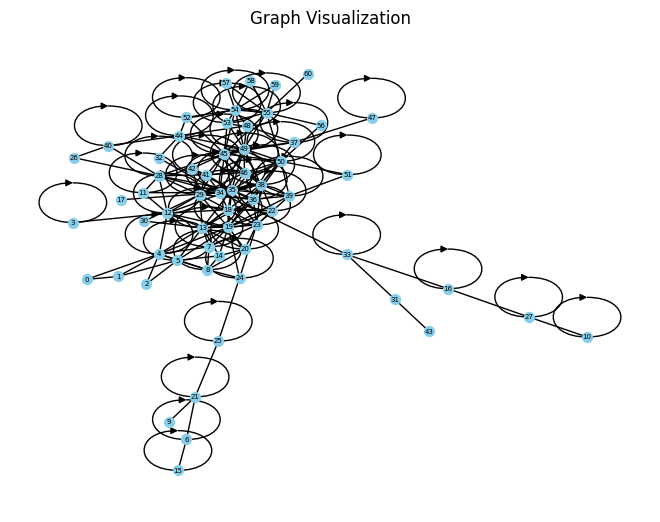

Graph data: Data(x=[61, 4], edge_index=[2, 100000], edge_attr=[100000, 2])
Number of nodes: 61
Number of edges: 100000


In [66]:
def build_graph(transitions, bins_per_dim=15):
    node_features_dict = {}  # node_id -> feature vector
    edges = []  # (src, dst)
    edge_attrs = []  # (action, reward)

    for (s, a, r, s_next) in transitions:
        src_id, (cp, cv, pa, pv) = discretize_state(s, bins_per_dim)
        dst_id, (cp2, cv2, pa2, pv2) = discretize_state(s_next, bins_per_dim)

        # Store node features
        if src_id not in node_features_dict:
            # Normalize features to be in [0,1]
            node_features_dict[src_id] = np.array([cp, cv, pa, pv], dtype=np.float32) / (bins_per_dim-1)
        if dst_id not in node_features_dict:
            node_features_dict[dst_id] = np.array([cp2, cv2, pa2, pv2], dtype=np.float32) / (bins_per_dim-1)

        edges.append([src_id, dst_id])
        edge_attrs.append([a, r])

    # Convert to torch tensors
    # Remap node_ids to a contiguous range
    unique_nodes = sorted(node_features_dict.keys())
    node_id_map = {nid: i for i, nid in enumerate(unique_nodes)}
    x = torch.tensor([node_features_dict[nid] for nid in unique_nodes], dtype=torch.float)

    edge_index = torch.tensor([[node_id_map[e[0]] for e in edges],
                               [node_id_map[e[1]] for e in edges]], dtype=torch.long)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data, node_id_map

import networkx as nx
def visualize_graph(graph_data, node_id_map):
    """Visualizes a PyTorch Geometric graph using NetworkX and matplotlib."""

    G = nx.Graph()

    # Add nodes
    for i in range(graph_data.num_nodes):
        G.add_node(i)

    # Add edges
    edge_list = graph_data.edge_index.t().tolist()
    for edge in edge_list:
        G.add_edge(edge[0], edge[1])

    # Node positions
    pos = nx.spring_layout(G)

    # Draw nodes and edges
    # nx.draw(G, pos, with_labels=True, node_size=70, node_color="skyblue", font_size=3)
    nx.draw(G, pos, with_labels=True, node_size=50, node_color="skyblue", font_size=5, arrowsize=10, arrowstyle='-|>', connectionstyle='arc3,rad=0.1')  # Added arrow settings
    plt.title("Graph Visualization")
    plt.show()
graph_data, node_id_map = build_graph(transitions, bins_per_dim=5)
visualize_graph(graph_data, node_id_map)
print("Graph data:", graph_data)
print("Number of nodes:", graph_data.num_nodes)
print("Number of edges:", graph_data.num_edges)


In [49]:
class GCNEmbedding(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=16):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [50]:
gnn = GCNEmbedding(in_channels=4, hidden_channels=32, out_channels=16)
node_embeddings = gnn(graph_data)
print("Node embeddings shape:", node_embeddings.shape)


Node embeddings shape: torch.Size([61, 16])


In [51]:
inv_node_id_map = {v: k for k, v in node_id_map.items()}
node_embedding_dict = {}
for node_idx in range(node_embeddings.shape[0]):
    node_embedding_dict[inv_node_id_map[node_idx]] = node_embeddings[node_idx].detach()

def get_state_embedding(obs, bins_per_dim=5):
    node_id, _ = discretize_state(obs, bins_per_dim)
    if node_id in node_embedding_dict:
        return node_embedding_dict[node_id].numpy()
    else:
        # If out-of-range state occurs, fallback to zero embedding
        return np.zeros(16, dtype=np.float32)

In [52]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3 import PPO
from stable_baselines3.common.utils import obs_as_tensor

class GNNFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, bins_per_dim=5):
        super().__init__(observation_space, features_dim=4+16) # raw state (4) + embedding (16)
        self.bins_per_dim = bins_per_dim

    def forward(self, obs):
        # obs shape: (batch_size, 4)
        # For each obs, get embedding
        obs_np = obs.detach().cpu().numpy()
        embeddings = [get_state_embedding(o, self.bins_per_dim) for o in obs_np]
        embeddings = torch.tensor(embeddings, dtype=torch.float, device=obs.device)
        # Concatenate raw obs and embedding
        return torch.cat([obs, embeddings], dim=1)


#### GNN Training

Logging to ./logs_gnn/


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23       |
|    ep_rew_mean     | 23       |
| time/              |          |
|    fps             | 854      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.8        |
|    ep_rew_mean          | 27.8        |
| time/                   |             |
|    fps                  | 488         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009531729 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.685      |
|    explained_variance   | -0.00974    |
|    learning_rate        | 0.

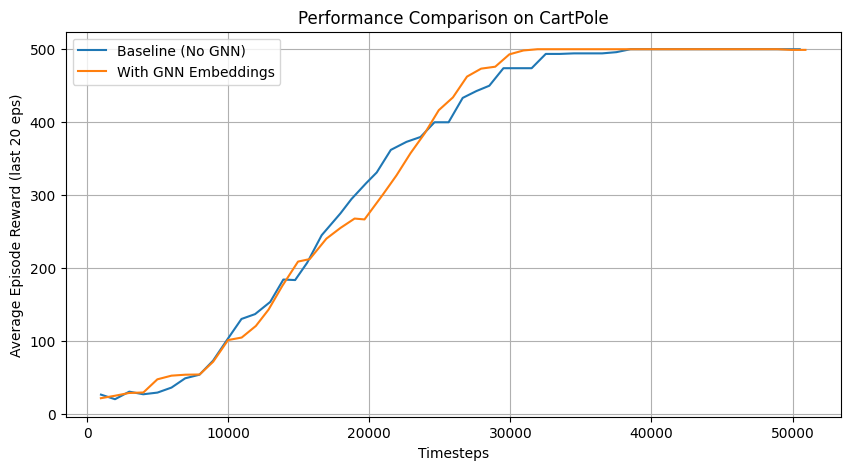

In [53]:
# Changes for the GNN experiment

# 1. Set a log directory for GNN
log_dir_gnn = "./logs_gnn/"
os.makedirs(log_dir_gnn, exist_ok=True)

# 2. Create and wrap the environment in the same way as the baseline
env_gnn = gym.make("CartPole-v1")
env_gnn = Monitor(env_gnn, log_dir_gnn + "monitor.csv")
env_gnn = DummyVecEnv([lambda: env_gnn])
env_gnn = VecMonitor(env_gnn)

# 3. Configure the logger for the GNN model
gnn_logger = configure(log_dir_gnn, ["stdout", "csv", "tensorboard"])

# 4. Initialize the GNN-based model
# We assume GNNFeaturesExtractor was defined as before.
policy_kwargs = dict(
    features_extractor_class=GNNFeaturesExtractor,
)

gnn_model = PPO("MlpPolicy", env_gnn, policy_kwargs=policy_kwargs, verbose=0)
gnn_model.set_logger(gnn_logger)

# 5. Define and use the callback to track rewards during training
gnn_callback = RewardTrackerCallback(check_freq=1000, window_size=20)
gnn_model.learn(total_timesteps=50000, callback=gnn_callback)

# After training:
gnn_rewards = gnn_callback.rewards
gnn_timesteps = gnn_callback.timesteps

# 6. Plot results (assuming baseline's results are in baseline_timesteps and baseline_rewards)
plt.figure(figsize=(10,5))
plt.plot(baseline_timesteps, baseline_rewards, label="Baseline (No GNN)")
plt.plot(gnn_timesteps, gnn_rewards, label="With GNN Embeddings")
plt.xlabel("Timesteps")
plt.ylabel("Average Episode Reward (last 20 eps)")
plt.title("Performance Comparison on CartPole")
plt.legend()
plt.grid(True)
plt.show()


## Collecting meaningful transitions

In [54]:
class TransitionRecorderCallback(BaseCallback):
    def __init__(self):
        super().__init__(verbose=0)
        self.transitions = []
        self.last_obs = None
        self.last_done = True

    def _on_training_start(self):
        obs = self.model.env.reset()[0]
        self.last_obs = obs

    def _on_step(self):
        # self.model.env is a VecEnv, so we need to use .env_method or get_attr to access monitor
        # We can record transitions through info dictionaries or by wrapping the env differently.
        # For simplicity, we’ll assume the environment is a single DummyVecEnv with a Monitor.

        # `self.model.env.step_wait()` is already done internally by PPO, so we have info.
        # Let's extract info and actions from the model runner.
        # PPO doesn't expose transitions directly at this callback point, we need to do a trick:

        # Actually, an easier approach is to store transitions at the environment level.
        # Let’s define a custom wrapper that stores transitions.
        return True


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
class TransitionRecorderWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.recorded_transitions = []
        self.last_obs = None

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.last_obs = obs
        return obs, info

    def step(self, action):
        next_obs, reward, done, truncated, info = self.env.step(action)
        self.recorded_transitions.append((self.last_obs, action, reward, next_obs))
        self.last_obs = next_obs
        return next_obs, reward, done, truncated, info


#### PPO for 10K timesteps

In [56]:
log_dir_partial = "./logs_partial/"
os.makedirs(log_dir_partial, exist_ok=True)

base_env = gym.make("CartPole-v1")
record_env = TransitionRecorderWrapper(base_env)
env_partial = Monitor(record_env, log_dir_partial)
env_partial = DummyVecEnv([lambda: env_partial])
env_partial = VecMonitor(env_partial)

partial_logger = configure(log_dir_partial, ["stdout", "csv", "tensorboard"])

# Increase entropy coefficient to encourage exploration
partial_model = PPO("MlpPolicy", env_partial, verbose=0, ent_coef=0.01)
partial_model.set_logger(partial_logger)

partial_model.learn(total_timesteps=10000)

# Retrieve transitions
partial_transitions = record_env.recorded_transitions
print("Number of transitions collected (partial):", len(partial_transitions))


Logging to ./logs_partial/


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.9     |
|    ep_rew_mean     | 21.9     |
| time/              |          |
|    fps             | 1053     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 23.5        |
|    ep_rew_mean          | 23.5        |
| time/                   |             |
|    fps                  | 790         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009098539 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | 0.00237     |
|    learning_rate        | 0.

In [57]:
def create_bins(low, high, bins):
    return np.linspace(low, high, bins+1)

def discretize_state(obs, bins_per_dim=50):
    cart_pos_bins = create_bins(-4.8, 4.8, bins_per_dim)
    cart_vel_bins = create_bins(-3.0, 3.0, bins_per_dim)
    pole_angle_bins = create_bins(-0.418, 0.418, bins_per_dim)
    pole_vel_bins = create_bins(-3.0, 3.0, bins_per_dim)

    def get_bin(value, b):
        return np.digitize(value, b)-1

    cp = get_bin(obs[0], cart_pos_bins)
    cv = get_bin(obs[1], cart_vel_bins)
    pa = get_bin(obs[2], pole_angle_bins)
    pv = get_bin(obs[3], pole_vel_bins)
    node_id = cp + cv*(5) + pa*(5**2) + pv*(5**3)
    return node_id, (cp, cv, pa, pv)

def build_graph(transitions, bins_per_dim=50):
    node_features_dict = {}
    edges = []
    edge_attrs = []

    for (s, a, r, s_next) in transitions:
        src_id, (cp, cv, pa, pv) = discretize_state(s, bins_per_dim)
        dst_id, (cp2, cv2, pa2, pv2) = discretize_state(s_next, bins_per_dim)

        if src_id not in node_features_dict:
            node_features_dict[src_id] = np.array([cp, cv, pa, pv], dtype=np.float32)/(bins_per_dim-1)
        if dst_id not in node_features_dict:
            node_features_dict[dst_id] = np.array([cp2, cv2, pa2, pv2], dtype=np.float32)/(bins_per_dim-1)

        edges.append([src_id, dst_id])
        edge_attrs.append([a, r])

    unique_nodes = sorted(node_features_dict.keys())
    node_id_map = {nid: i for i, nid in enumerate(unique_nodes)}
    x = torch.tensor([node_features_dict[nid] for nid in unique_nodes], dtype=torch.float)
    edge_index = torch.tensor([[node_id_map[e[0]] for e in edges],
                               [node_id_map[e[1]] for e in edges]], dtype=torch.long)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data, node_id_map


In [58]:
graph_data, node_id_map = build_graph(partial_transitions, bins_per_dim=50)
print("Graph data:", graph_data)


Graph data: Data(x=[2297, 4], edge_index=[2, 10240], edge_attr=[10240, 2])


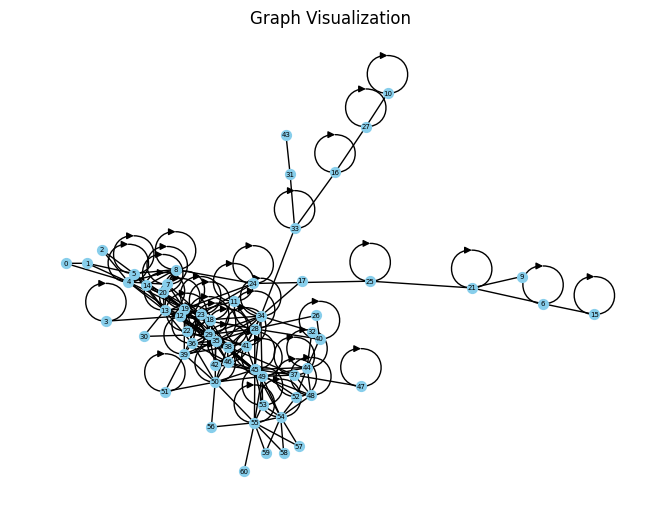

Graph data: Data(x=[61, 4], edge_index=[2, 100000], edge_attr=[100000, 2])
Number of nodes: 61
Number of edges: 100000


In [67]:
visualize_graph(graph_data, node_id_map)
print("Graph data:", graph_data)
print("Number of nodes:", graph_data.num_nodes)
print("Number of edges:", graph_data.num_edges)

In [60]:
class GCNEmbedding(nn.Module):
    def __init__(self, in_channels, hidden_channels=32, out_channels=16):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

gnn = GCNEmbedding(in_channels=4, hidden_channels=32, out_channels=16)
with torch.no_grad():
    node_embeddings = gnn(graph_data)

inv_node_id_map = {v: k for k, v in node_id_map.items()}
node_embedding_dict = {}
for node_idx in range(node_embeddings.shape[0]):
    node_embedding_dict[inv_node_id_map[node_idx]] = node_embeddings[node_idx].detach()

def get_state_embedding(obs, bins_per_dim=5):
    node_id, _ = discretize_state(obs, bins_per_dim)
    if node_id in node_embedding_dict:
        return node_embedding_dict[node_id].numpy()
    else:
        return np.zeros(16, dtype=np.float32)


In [61]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class GNNFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, bins_per_dim=5):
        super().__init__(observation_space, features_dim=4+16) # 4 state dims + 16 embed
        self.bins_per_dim = bins_per_dim

    def forward(self, obs):
        obs_np = obs.detach().cpu().numpy()
        embeddings = [get_state_embedding(o, self.bins_per_dim) for o in obs_np]
        embeddings = torch.tensor(embeddings, dtype=torch.float, device=obs.device)
        return torch.cat([obs, embeddings], dim=1)


In [64]:
log_dir_gnn = "./logs_gnn_enhanced/"
os.makedirs(log_dir_gnn, exist_ok=True)

env_gnn = gym.make("CartPole-v1")
env_gnn = Monitor(env_gnn, log_dir_gnn + "monitor.csv")
env_gnn = DummyVecEnv([lambda: env_gnn])
env_gnn = VecMonitor(env_gnn)

gnn_logger = configure(log_dir_gnn, ["stdout", "csv", "tensorboard"])

policy_kwargs = dict(
    features_extractor_class=GNNFeaturesExtractor,
    features_extractor_kwargs=dict(bins_per_dim=5)
)

gnn_model = PPO("MlpPolicy", env_gnn, policy_kwargs=policy_kwargs, verbose=0)
gnn_model.set_logger(gnn_logger)

# Use a reward tracking callback from previous approach
class RewardTrackerCallback(BaseCallback):
    def __init__(self, verbose=0, check_freq=1000, window_size=20):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.window_size = window_size
        self.rewards = []
        self.timesteps = []

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            from stable_baselines3.common.results_plotter import load_results, ts2xy
            x, y = ts2xy(load_results(self.model.logger.dir), 'timesteps')
            if len(y) >= self.window_size:
                mean_reward = np.mean(y[-self.window_size:])
                self.rewards.append(mean_reward)
                self.timesteps.append(x[-1])
        return True

gnn_callback = RewardTrackerCallback()
gnn_model.learn(total_timesteps=50000, callback=gnn_callback)

gnn_rewards_partial = gnn_callback.rewards
gnn_timesteps_partial = gnn_callback.timesteps


Logging to ./logs_gnn_enhanced/


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 20.6     |
| time/              |          |
|    fps             | 876      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25.6        |
|    ep_rew_mean          | 25.5        |
| time/                   |             |
|    fps                  | 442         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007814654 |
|    clip_fraction        | 0.07        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | 0.000393    |
|    learning_rate        | 0.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


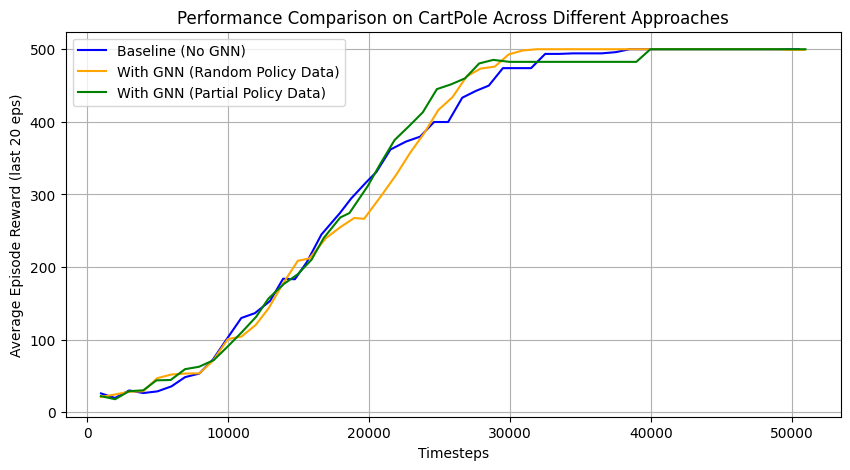

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
# Plot Baseline
plt.plot(baseline_timesteps, baseline_rewards, label="Baseline (No GNN)", color="blue")
# Plot GNN from Random Policy Data (previous approach)
plt.plot(gnn_timesteps, gnn_rewards, label="With GNN (Random Policy Data)", color="orange")
# Plot GNN from Partially-Trained Policy Data (current approach)
plt.plot(gnn_timesteps_partial, gnn_rewards_partial, label="With GNN (Partial Policy Data)", color="green")

plt.xlabel("Timesteps")
plt.ylabel("Average Episode Reward (last 20 eps)")
plt.title("Performance Comparison on CartPole Across Different Approaches")
plt.legend()
plt.grid(True)
plt.show()
